In [33]:
%pip install -r requirements_part1.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Imports
import pandas as pd
from transformers import pipeline


In [ ]:
# Load training data
df_all_features = pd.read_csv('liar2/train.csv')

df_all_features.head(3)

,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,half_true_counts,mostly_false_counts,false_counts,pants_on_fire_counts,context,justification
0,13847,5,"90 percent of Americans ""support universal bac...","October 2, 2017",government regulation;polls and public opinion...,chris abele,"Chris Abele is Milwaukee County Executive, a p...",wisconsin,1,4,5,3,5,2,a tweet,"""Universal"" is the term for background checks ..."
1,13411,1,Last year was one of the deadliest years ever ...,"May 19, 2017",after the fact;congress;criminal justice;histo...,thom tillis,Thom Tillis is a Republican who serves as U.S....,north carolina,0,2,7,3,2,0,a press release supporting the Back The Blue A...,"Sen. Thom Tillis, a North Carolina Republican,..."
2,10882,0,"Bernie Sanders's plan is ""to raise your taxes ...","October 28, 2015",taxes,chris christie,"Chris Christie announced June 6, 2023 that he ...",national,21,20,27,11,17,8,"Boulder, Colo","Christie said that Sanders’s plan is ""to raise..."


In [36]:
df = df_all_features[["statement", "label"]]
df.head(3)

,statement,label
0,"90 percent of Americans ""support universal bac...",5
1,Last year was one of the deadliest years ever ...,1
2,"Bernie Sanders's plan is ""to raise your taxes ...",0


# 1. RoBERT
- PER (Person names)
- ORG (Organizations)
- LOC (Locations)
- MISC (Other special entities)

In [37]:

# Load RoBERTa NER model
ner_pipeline_roberta = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english")

def clean_entity(entity):
    """Removes tokenization artifacts and filters out unwanted characters."""
    word = entity["word"].replace("Ġ", "").strip()  # Remove subword markers
    if len(word) > 1 and word.isalpha():  # Keep only proper words
        return (word, entity["entity"])
    return None  # Ignore bad entities

def extract_entities(text):
    """Runs RoBERTa NER and cleans extracted entities."""
    if isinstance(text, str) and text.strip():
        entities = ner_pipeline_roberta(text)
        return [e for e in (clean_entity(ent) for ent in entities) if e]  # Apply filtering
    return []

# Apply NER extraction + cleaning
df_RoBert = df.copy()
df_RoBert.loc[:, "clean_entities"] = df["statement"].apply(extract_entities)

# Show first few rows
df_RoBert

Device set to use mps:0


,statement,label,clean_entities
0,"90 percent of Americans ""support universal bac...",5,"[(Americans, MISC)]"
1,Last year was one of the deadliest years ever ...,1,[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,"[(Bernie, PER), (Sanders, PER)]"
3,Voter ID is supported by an overwhelming major...,4,"[(NY, MISC), (ers, MISC)]"
4,"Says Barack Obama ""robbed Medicare (of) $716 b...",2,"[(Barack, PER), (Obama, PER), (Medicare, MISC)..."
5,"Video says COVID-19 vaccines are ""weapons of m...",0,"[(CO, MISC), (VID, MISC)]"
6,Says Jeff Reardon cut elementary school music ...,2,"[(Jeff, PER), (Re, PER), (ardon, PER)]"


In [40]:
true_labels = [3,4, 5]   # True, Mostly-true,    .............Half-true will be skipped
false_labels = [0, 1,2]  # Mostly-false will be skipped.....,False, Pants on Fire

# Split into true and false news DataFrames
df_RoBert_true = df_RoBert[df_RoBert["label"].isin(true_labels)]
df_RoBert_false = df_RoBert[df_RoBert["label"].isin(false_labels)]

In [41]:
df_RoBert_false.head(3)

,statement,label,clean_entities
1,Last year was one of the deadliest years ever ...,1,[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,"[(Bernie, PER), (Sanders, PER)]"
4,"Says Barack Obama ""robbed Medicare (of) $716 b...",2,"[(Barack, PER), (Obama, PER), (Medicare, MISC)..."


In [42]:
df_RoBert_true.head(3)

,statement,label,clean_entities
0,"90 percent of Americans ""support universal bac...",5,"[(Americans, MISC)]"
3,Voter ID is supported by an overwhelming major...,4,"[(NY, MISC), (ers, MISC)]"


In [46]:
import pandas as pd
from collections import Counter

def count_entities_with_type(df):
    """Counts occurrences of each entity (name, type) and returns a DataFrame."""
    all_entities = [
        (entity[0], entity[1]) for entities in df["clean_entities"] if entities for entity in entities
    ]
    
    entity_counts = Counter(all_entities).most_common()  # Count all entities

    # ✅ Fix: Unpack entity tuple correctly
    df_entities = pd.DataFrame(
        [(ent[0], ent[1], count) for ent, count in entity_counts],
        columns=["Entity", "Type", "Count"]
    )

    return df_entities

# Apply to true and false news
df_RoBert_true_entities = count_entities_with_type(df_RoBert_true)
df_RoBert_false_entities = count_entities_with_type(df_RoBert_false)


df_RoBert_false_entities.head(3)


,Entity,Type,Count
0,Bernie,PER,1
1,Sanders,PER,1
2,Barack,PER,1


In [47]:
df_RoBert_true_entities.head(3)

,Entity,Type,Count
0,Americans,MISC,1
1,NY,MISC,1
2,ers,MISC,1


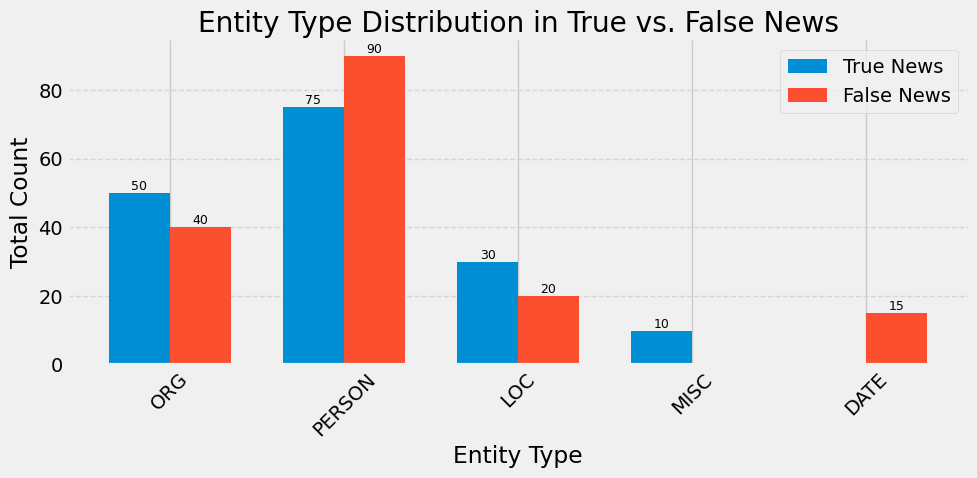

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# SAMPLE DATA: Replace these with your actual groupby results
import pandas as pd
data_true = {'Type': ['ORG','PERSON','LOC','MISC'], 'Count': [50, 75, 30, 10]}
data_false = {'Type': ['ORG','PERSON','LOC','DATE'], 'Count': [40, 90, 20, 15]}
df_RoBert_true_entities = pd.DataFrame(data_true)
df_RoBert_false_entities = pd.DataFrame(data_false)

# Get entity types and their counts
true_counts = df_RoBert_true_entities.groupby("Type")["Count"].sum()
false_counts = df_RoBert_false_entities.groupby("Type")["Count"].sum()

# Align both datasets to have the same entity types
all_types = list(set(true_counts.index).union(set(false_counts.index)))
true_counts = true_counts.reindex(all_types, fill_value=0)
false_counts = false_counts.reindex(all_types, fill_value=0)

# Set up bar positions
x = np.arange(len(all_types))
width = 0.35  # Bar width

# Use a modern style
plt.style.use('fivethirtyeight')

# Create the figure
plt.figure(figsize=(10, 5))

# Plot bars side by side (colors automatically picked by Matplotlib)
bars_true = plt.bar(x - width/2, true_counts, width, label="True News")
bars_false = plt.bar(x + width/2, false_counts, width, label="False News")

# Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines for a cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and styling
plt.xlabel("Entity Type")
plt.ylabel("Total Count")
plt.title("Entity Type Distribution in True vs. False News")
plt.xticks(x, all_types, rotation=45)
plt.legend()

# (Optional) Annotate the bars with their exact values
for bar_group in [bars_true, bars_false]:
    for bar in bar_group:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height}",
                ha="center",
                va="bottom",
                fontsize=9
            )

# Show plot
plt.tight_layout()
plt.show()